# Setup

In [2]:
import pandas as pd
import polars as pl 
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from tools import preprocess, get_corpus_list
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (confusion_matrix)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_d

In [3]:
data = pl.read_csv("./dataset.csv")

In [4]:
data.head()

app_id,app_name,review_text,review_score,review_votes
i64,str,str,i64,i64
10,"""Counter-Strike""","""Ruined my life.""",1,0
10,"""Counter-Strike""","""This will be more of a ''my ex…",1,1
10,"""Counter-Strike""","""This game saved my virginity.""",1,0
10,"""Counter-Strike""","""• Do you like original games? …",1,0
10,"""Counter-Strike""",""" Easy to learn, hard to…",1,1


In [5]:
data.shape

(6417106, 5)

In [6]:
data["review_score"].value_counts()["review_score"]

review_score
i64
1
-1


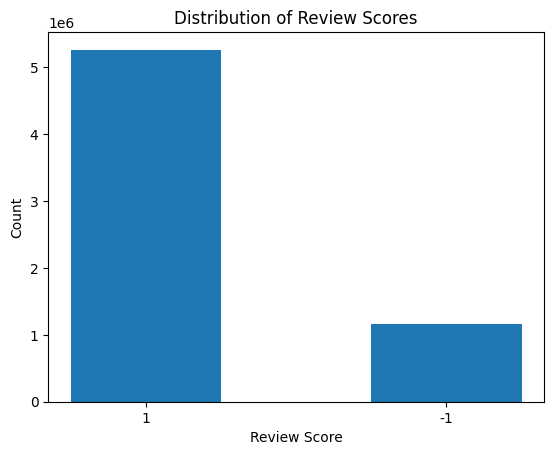

In [7]:
value_counts = data["review_score"].value_counts()
cols = value_counts["review_score"].to_numpy().astype(str)
counts = value_counts["count"].to_numpy() 

plt.bar(cols, counts, width=0.5)
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores")
plt.show()

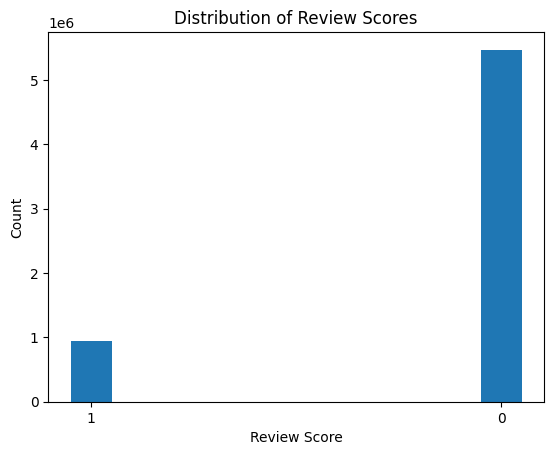

In [8]:
value_counts = data["review_votes"].value_counts()
cols = value_counts["review_votes"].to_numpy().astype(str)
counts = value_counts["count"].to_numpy() 

plt.bar(cols, counts, width=0.1)
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Distribution of Review Scores")
plt.show()

# Tiền xử lý dữ liệu

In [9]:
data.null_count()

app_id,app_name,review_text,review_score,review_votes
u32,u32,u32,u32,u32
0,183234,7305,0,0


In [10]:
data.null_count()*100/len(data)

app_id,app_name,review_text,review_score,review_votes
f64,f64,f64,f64,f64
0.0,2.855399,0.113836,0.0,0.0


In [11]:
data["review_text"].null_count()/len(data)

0.0011383636174936177

In [12]:
data = data[:, ["review_text", "review_votes"]]

In [13]:
data = data.drop_nulls()

In [14]:
data.null_count()*100/len(data)

review_text,review_votes
f64,f64
0.0,0.0


In [15]:
data = data.unique()

In [16]:
data.shape

(4483987, 2)

# Chọn dữ liệu nhỏ hơn

In [17]:
n_sample = 2500

In [18]:
# Tron du lieu dam bao tinh ngau nhien
shuffled_data = data.sample(fraction=1, shuffle=True, seed=42)

In [19]:
# Lay n phan tu cua tieu cuc
votes_0 = shuffled_data.filter(pl.col("review_votes") == 0)
votes_0 = votes_0.head(n_sample)
votes_0.head()

review_text,review_votes
str,i64
"""I was in a futuristic plane sh…",0
"""As a game it is pretty good th…",0
"""I'v not spend much time on SFM…",0
"""This is the most beautiful gam…",0
"""What can I say about L4D2 that…",0


In [20]:
votes_1 = shuffled_data.filter(pl.col("review_votes") == 1)
votes_1 = votes_1.head(n_sample)
votes_1.head()

review_text,review_votes
str,i64
"""Best championship manager ever…",1
"""I was really excited for this …",1
"""Raid boss down. Equipment: Pe…",1
"""I'm nuts for this game!""",1
"""worst 2k series ever..... if 2…",1


In [21]:
small_data = pl.concat([votes_0, votes_1])
print(small_data["review_votes"].unique())
small_data.shape

shape: (2,)
Series: 'review_votes' [i64]
[
	0
	1
]


(5000, 2)

In [22]:
docs = small_data["review_text"]
y = small_data["review_votes"]

In [23]:
docs = preprocess(docs.to_numpy())
docs = get_corpus_list(docs)
X = docs

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [25]:
X = X.toarray()

In [28]:
feature_names = vectorizer.get_feature_names_out()
max_tfidf_scores = X.max(axis=0)
top_n = 10
top_indices = np.argsort(max_tfidf_scores)[-top_n:][::-1]
top_words = [(feature_names[i], max_tfidf_scores[i]) for i in top_indices]


In [29]:
for word, score in top_words:
    print(f"{word}: {score:.4f}")

overr: 1.0000
quack: 1.0000
card: 1.0000
opinion: 1.0000
boarderland: 1.0000
clasic: 1.0000
uniqu: 1.0000
cold: 1.0000
complic: 1.0000
realism: 1.0000


# Chia dữ liệu

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, stratify=y)

# ML

## Logistic Regression

In [86]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

log_pred = log_reg.predict(X_test)
log_cfs_mtx = confusion_matrix(log_pred, y_test)

<Axes: >

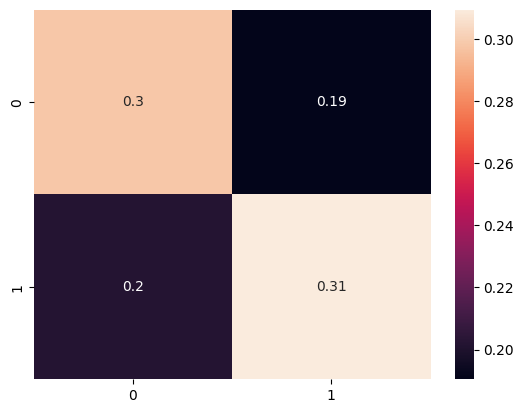

In [87]:
sns.heatmap(log_cfs_mtx/np.sum(log_cfs_mtx), annot=True)

## Naive Bayes

In [88]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

nb_pred = gaussian_nb.predict(X_test)
nb_cfs_mtx = confusion_matrix(nb_pred, y_test)

<Axes: >

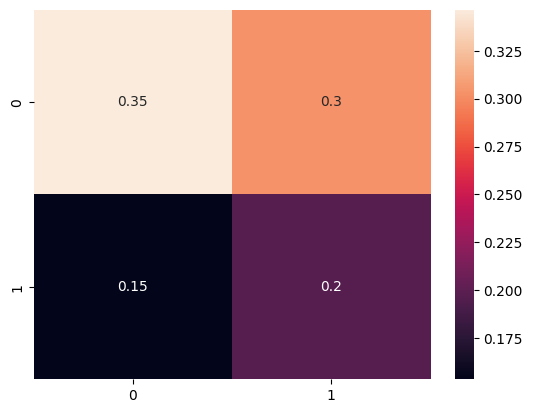

In [89]:
sns.heatmap(nb_cfs_mtx/np.sum(nb_cfs_mtx), annot=True)

## Simple RNN

In [108]:
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing import sequence


In [109]:
max_words = 5000
embd_len = 32

In [110]:
x_texts = docs

In [111]:
x_train, x_test, y_train, y_test = train_test_split(x_texts, y, shuffle=True, random_state=42, stratify=y)

In [114]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

In [115]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [116]:
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)

In [117]:
# Tạo Simple RNN
RNN_model = Sequential(name="Simple_RNN")
RNN_model.add(Embedding(max_words, # Input
                        embd_len, # Output
                        input_length=max_words))

RNN_model.add(SimpleRNN(128,
                        activation='tanh',
                        return_sequences=False))

# Kết quả trả về là nhị phân
RNN_model.add(Dense(1, activation='sigmoid'))

# Summary
print(RNN_model.summary())

# Compiling model
RNN_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the model
history = RNN_model.fit(x_train, y_train,
                        batch_size=64,
                        epochs=5,
                        verbose=1,
                        validation_data=(x_test, y_test))

# Printing model score on test data
print()
print("Simple_RNN Score---> ", RNN_model.evaluate(x_test, y_test, verbose=0))


c:\Users\nguye\miniconda3\envs\nlp\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.4925 - loss: 0.6975 - val_accuracy: 0.5144 - val_loss: 0.6929
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.5908 - loss: 0.6825 - val_accuracy: 0.5280 - val_loss: 0.6922
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.5921 - loss: 0.6816 - val_accuracy: 0.5120 - val_loss: 0.6925
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.6409 - loss: 0.6773 - val_accuracy: 0.5160 - val_loss: 0.6922
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.7424 - loss: 0.6603 - val_accuracy: 0.5112 - val_loss: 0.6952

Simple_RNN Score--->  [0.6951904296875, 0.5112000107765198]


In [119]:
rnn_pred = RNN_model.predict(x_test)
rnn_pred = np.where(rnn_pred >= 0.5, 1, 0)

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step


<Axes: >

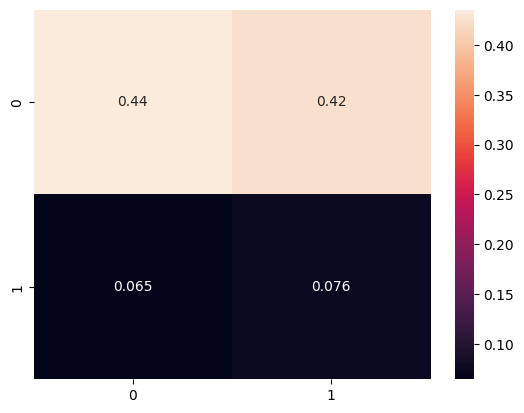

In [121]:
rnn_cfs_mtx = confusion_matrix(rnn_pred, y_test)
sns.heatmap(rnn_cfs_mtx/np.sum(rnn_cfs_mtx), annot=True)